In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
columns = [
    "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9",
    "A10", "A11", "A12", "A13", "A14", "A15", "Class"
]

credit_approval = pd.read_csv(url, names=columns, na_values="?")

In [ ]:
credit_approval.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,Class
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,202.0,0,0
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,0,43.0,560,0
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,0,280.0,824,0
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,1,0,100.0,3,0
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,0,2,120.0,0,0


In [ ]:
credit_approval.head(5).drop(['A2','A3','A8','A14','A11','A15','Class'],axis=1)

,A1,A4,A5,A6,A7,A9,A10,A12,A13
0,1,1,0,12,7,1,1,0,0
1,0,1,0,10,3,1,1,0,0
2,0,1,0,10,3,1,0,0,0
3,1,1,0,12,7,1,1,1,0
4,1,1,0,12,7,1,0,0,2


In [ ]:
len(credit_approval)

690

In [ ]:
#Fill missing values
numeric_cols = credit_approval.select_dtypes(include=['float64', 'int64']).columns
credit_approval[numeric_cols] = credit_approval[numeric_cols].fillna(credit_approval[numeric_cols].mean())

categorical_cols = credit_approval.select_dtypes(include=['object']).columns
for col in categorical_cols:
    credit_approval[col].fillna(credit_approval[col].mode()[0], inplace=True)

<ipython-input-6-212898a4bb3d>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  credit_approval[col].fillna(credit_approval[col].mode()[0], inplace=True)


In [ ]:
le = LabelEncoder()
for column in credit_approval.select_dtypes(include=['object']).columns:
    credit_approval[column] = le.fit_transform(credit_approval[column])

In [ ]:
X = credit_approval.iloc[:, :-1]
y = credit_approval.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
#Classificaton rule
rules = export_text(clf, feature_names=list(X.columns))
print(rules)

|--- A9 <= 0.50
|   |--- A4 <= 0.50
|   |   |--- class: 0
|   |--- A4 >  0.50
|   |   |--- A3 <= 0.17
|   |   |   |--- A14 <= 172.01
|   |   |   |   |--- class: 1
|   |   |   |--- A14 >  172.01
|   |   |   |   |--- A2 <= 35.67
|   |   |   |   |   |--- A12 <= 0.50
|   |   |   |   |   |   |--- A5 <= 1.00
|   |   |   |   |   |   |   |--- A2 <= 30.08
|   |   |   |   |   |   |   |   |--- A6 <= 5.50
|   |   |   |   |   |   |   |   |   |--- A2 <= 21.80
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- A2 >  21.80
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- A6 >  5.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- A2 >  30.08
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- A5 >  1.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- A12 >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- A2 >  35.67
|   |   | 

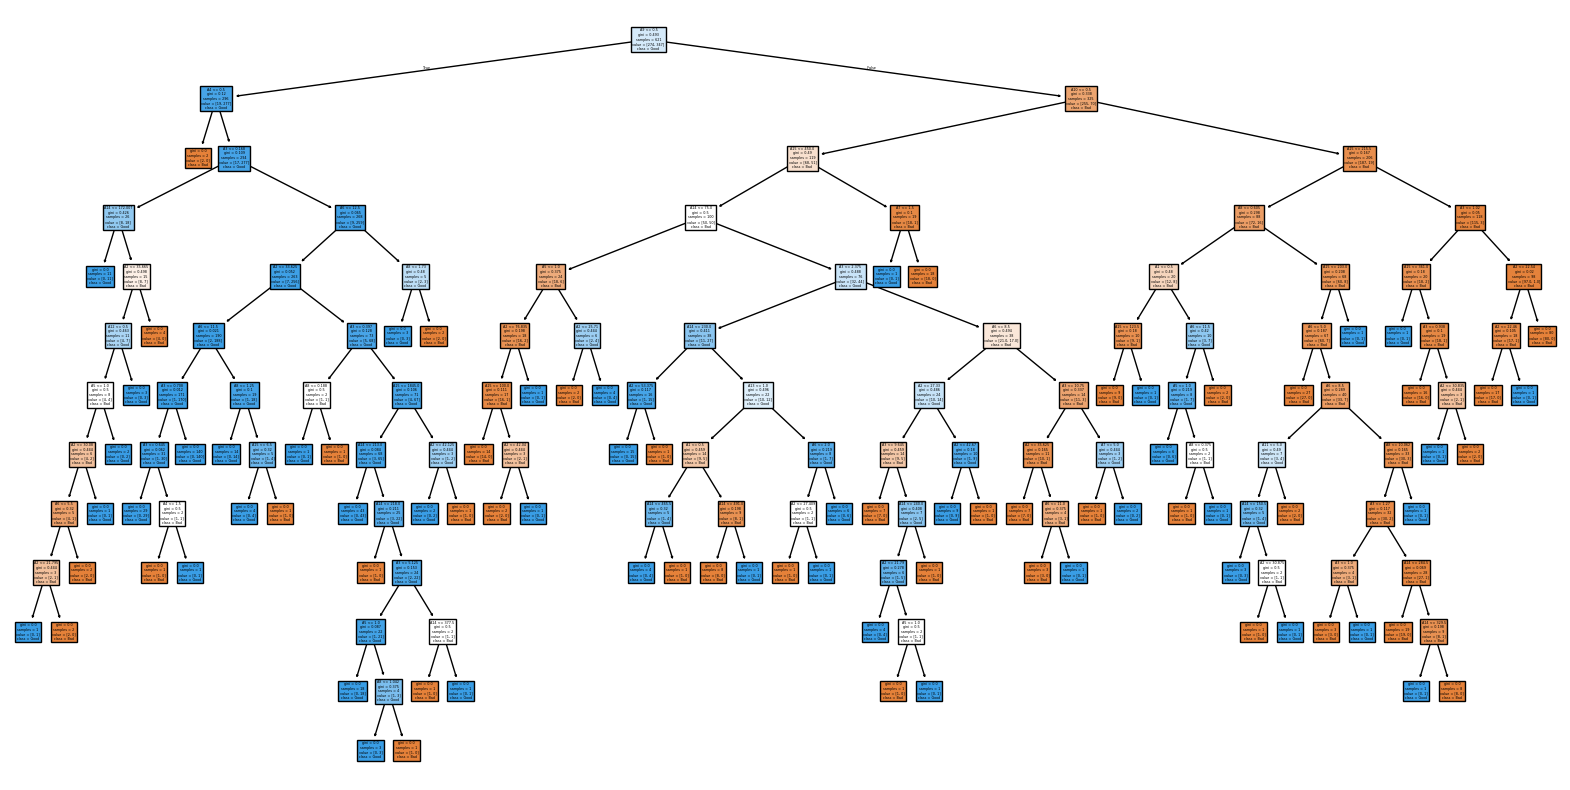

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=["Bad", "Good"], filled=True)
plt.show()

In [ ]:
def tree_to_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    rules = []

    def recurse(node, depth, rule):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Append condition to current rule
            left_rule = rule + [f"{name} <= {threshold:.2f}"]
            right_rule = rule + [f"{name} > {threshold:.2f}"]
            recurse(tree_.children_left[node], depth + 1, left_rule)
            recurse(tree_.children_right[node], depth + 1, right_rule)
        else:
            # Append leaf node rule with class prediction
            value = tree_.value[node]
            class_label = value.argmax()  # Select the class with the highest value
            rules.append((rule, class_label))

    recurse(0, 0, [])

    return rules

In [ ]:
rules = tree_to_rules(clf, X_train.columns)

In [ ]:
rules

[(['A9 <= 0.50', 'A4 <= 0.50'], 0),
 (['A9 <= 0.50', 'A4 > 0.50', 'A3 <= 0.17', 'A14 <= 172.01'], 1),
 (['A9 <= 0.50',
   'A4 > 0.50',
   'A3 <= 0.17',
   'A14 > 172.01',
   'A2 <= 35.67',
   'A12 <= 0.50',
   'A5 <= 1.00',
   'A2 <= 30.08',
   'A6 <= 5.50',
   'A2 <= 21.80'],
  1),
 (['A9 <= 0.50',
   'A4 > 0.50',
   'A3 <= 0.17',
   'A14 > 172.01',
   'A2 <= 35.67',
   'A12 <= 0.50',
   'A5 <= 1.00',
   'A2 <= 30.08',
   'A6 <= 5.50',
   'A2 > 21.80'],
  0),
 (['A9 <= 0.50',
   'A4 > 0.50',
   'A3 <= 0.17',
   'A14 > 172.01',
   'A2 <= 35.67',
   'A12 <= 0.50',
   'A5 <= 1.00',
   'A2 <= 30.08',
   'A6 > 5.50'],
  0),
 (['A9 <= 0.50',
   'A4 > 0.50',
   'A3 <= 0.17',
   'A14 > 172.01',
   'A2 <= 35.67',
   'A12 <= 0.50',
   'A5 <= 1.00',
   'A2 > 30.08'],
  1),
 (['A9 <= 0.50',
   'A4 > 0.50',
   'A3 <= 0.17',
   'A14 > 172.01',
   'A2 <= 35.67',
   'A12 <= 0.50',
   'A5 > 1.00'],
  1),
 (['A9 <= 0.50',
   'A4 > 0.50',
   'A3 <= 0.17',
   'A14 > 172.01',
   'A2 <= 35.67',
   'A12 > 0

In [ ]:
#Print rules
i=1
for rule, outcome in rules:
    print(f"Rule{i}: {' AND '.join(rule)} => Class: {outcome}")
    i+=1

Rule1: A9 <= 0.50 AND A4 <= 0.50 => Class: 0
Rule2: A9 <= 0.50 AND A4 > 0.50 AND A3 <= 0.17 AND A14 <= 172.01 => Class: 1
Rule3: A9 <= 0.50 AND A4 > 0.50 AND A3 <= 0.17 AND A14 > 172.01 AND A2 <= 35.67 AND A12 <= 0.50 AND A5 <= 1.00 AND A2 <= 30.08 AND A6 <= 5.50 AND A2 <= 21.80 => Class: 1
Rule4: A9 <= 0.50 AND A4 > 0.50 AND A3 <= 0.17 AND A14 > 172.01 AND A2 <= 35.67 AND A12 <= 0.50 AND A5 <= 1.00 AND A2 <= 30.08 AND A6 <= 5.50 AND A2 > 21.80 => Class: 0
Rule5: A9 <= 0.50 AND A4 > 0.50 AND A3 <= 0.17 AND A14 > 172.01 AND A2 <= 35.67 AND A12 <= 0.50 AND A5 <= 1.00 AND A2 <= 30.08 AND A6 > 5.50 => Class: 0
Rule6: A9 <= 0.50 AND A4 > 0.50 AND A3 <= 0.17 AND A14 > 172.01 AND A2 <= 35.67 AND A12 <= 0.50 AND A5 <= 1.00 AND A2 > 30.08 => Class: 1
Rule7: A9 <= 0.50 AND A4 > 0.50 AND A3 <= 0.17 AND A14 > 172.01 AND A2 <= 35.67 AND A12 <= 0.50 AND A5 > 1.00 => Class: 1
Rule8: A9 <= 0.50 AND A4 > 0.50 AND A3 <= 0.17 AND A14 > 172.01 AND A2 <= 35.67 AND A12 > 0.50 => Class: 1
Rule9: A9 <= 0.50 A

asdf

In [ ]:
stable_attributes = ['A1', 'A2']
flexible_attributes = ["A4", "A5", "A6", "A7", "A8", "A9","A10", "A11", "A12"]

In [ ]:
# rules into equivalence classes based on stable attributes
def partition_rules_by_stable_attributes(rules, stable_attributes):
    partitioned_rules = {}
    for rule, outcome in rules:
        stable_values = tuple(r for r in rule if any(s in r for s in stable_attributes))
        if stable_values not in partitioned_rules:
            partitioned_rules[stable_values] = []
        partitioned_rules[stable_values].append((rule, outcome))
    return partitioned_rules

partitioned_rules = partition_rules_by_stable_attributes(rules, stable_attributes)

In [ ]:
partitioned_rules

{(): [(['A9 <= 0.50', 'A4 <= 0.50'], 0),
  (['A9 <= 0.50', 'A4 > 0.50', 'A3 > 0.17', 'A6 > 12.50', 'A8 <= 1.73'], 1),
  (['A9 <= 0.50', 'A4 > 0.50', 'A3 > 0.17', 'A6 > 12.50', 'A8 > 1.73'], 0)],
 ('A14 <= 172.01',): [(['A9 <= 0.50',
    'A4 > 0.50',
    'A3 <= 0.17',
    'A14 <= 172.01'],
   1)],
 ('A14 > 172.01',
  'A2 <= 35.67',
  'A12 <= 0.50',
  'A2 <= 30.08',
  'A2 <= 21.80'): [(['A9 <= 0.50',
    'A4 > 0.50',
    'A3 <= 0.17',
    'A14 > 172.01',
    'A2 <= 35.67',
    'A12 <= 0.50',
    'A5 <= 1.00',
    'A2 <= 30.08',
    'A6 <= 5.50',
    'A2 <= 21.80'],
   1)],
 ('A14 > 172.01',
  'A2 <= 35.67',
  'A12 <= 0.50',
  'A2 <= 30.08',
  'A2 > 21.80'): [(['A9 <= 0.50',
    'A4 > 0.50',
    'A3 <= 0.17',
    'A14 > 172.01',
    'A2 <= 35.67',
    'A12 <= 0.50',
    'A5 <= 1.00',
    'A2 <= 30.08',
    'A6 <= 5.50',
    'A2 > 21.80'],
   0)],
 ('A14 > 172.01',
  'A2 <= 35.67',
  'A12 <= 0.50',
  'A2 <= 30.08'): [(['A9 <= 0.50',
    'A4 > 0.50',
    'A3 <= 0.17',
    'A14 > 172.01',
  

In [ ]:
from itertools import combinations

In [ ]:
# Generate action rules
def generate_action_rules(partitioned_rules, flexible_attributes):
    action_rules = []
    for stable_group, rules_in_group in partitioned_rules.items():
        for (rule1, class1), (rule2, class2) in combinations(rules_in_group, 2):
            if class1 != class2:
                changes = []
                for r1, r2 in zip(rule1, rule2):
                    if any(f in r1 for f in flexible_attributes) and r1 != r2:
                        changes.append((r1, r2))
                if changes:
                    action_rule = {
                        "changes": changes,
                        "from_class": class1,
                        "to_class": class2
                    }
                    action_rules.append(action_rule)
    return action_rules

action_rules = generate_action_rules(partitioned_rules, flexible_attributes)

In [ ]:
action_rules

[{'changes': [('A4 <= 0.50', 'A4 > 0.50')], 'from_class': 0, 'to_class': 1},
 {'changes': [('A8 <= 1.73', 'A8 > 1.73')], 'from_class': 1, 'to_class': 0},
 {'changes': [('A4 <= 1.50', 'A4 > 1.50')], 'from_class': 0, 'to_class': 1},
 {'changes': [('A6 <= 11.50', 'A6 > 11.50')], 'from_class': 0, 'to_class': 1},
 {'changes': [('A8 <= 0.19', 'A8 > 0.19')], 'from_class': 1, 'to_class': 0},
 {'changes': [('A5 <= 1.00', 'A5 > 1.00')], 'from_class': 1, 'to_class': 0},
 {'changes': [('A8 <= 1.04', 'A8 > 1.04')], 'from_class': 1, 'to_class': 0},
 {'changes': [('A5 <= 1.00', 'A5 > 1.00')], 'from_class': 0, 'to_class': 1},
 {'changes': [('A6 <= 11.00', 'A6 > 11.00')], 'from_class': 0, 'to_class': 1},
 {'changes': [('A7 <= 5.00', 'A7 > 5.00')], 'from_class': 0, 'to_class': 1},
 {'changes': [('A7 <= 1.50', 'A7 > 1.50')], 'from_class': 1, 'to_class': 0},
 {'changes': [('A5 <= 1.00', 'A5 > 1.00')], 'from_class': 1, 'to_class': 0},
 {'changes': [('A6 <= 11.50', 'A6 > 11.50')], 'from_class': 1, 'to_class

In [ ]:
# Applyiing action rules to create a modified version
def apply_action_rules(data, action_rules, flexible_attributes):
    modified_data = data.copy()

    for action_rule in action_rules:
        changes = action_rule['changes']
        from_class = action_rule['from_class']
        to_class = 1

        matching_instances = modified_data[modified_data['Class'] == from_class]

        for change in changes:
            condition = change[0].split(' <= ')[0]
            old_value = float(change[0].split(' <= ')[1])
            new_value = float(change[1].split(' > ')[1])

            if condition in flexible_attributes:
                matching_instances[condition] = new_value

        modified_data.loc[matching_instances.index, 'Class'] = to_class

    return modified_data

modified_credit_approval = apply_action_rules(credit_approval, action_rules, flexible_attributes)

modified_credit_approval.to_csv("modified_credit_approval.csv", index=False)

<ipython-input-37-69395342d29a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_instances[condition] = new_value


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X_modified = modified_credit_approval.iloc[:, :-1]  # Features
y_modified = modified_credit_approval.iloc[:, -1]   # Target

y_pred_mod = clf.predict(X_modified)

accuracy_mod = accuracy_score(y_modified, y_pred_mod)
report_mod = classification_report(y_modified, y_pred_mod)

print(f"Accuracy on the modified dataset: {accuracy_mod * 100:.2f}%")
print("\nClassification Report:")
print(report_mod)


print(confusion_matrix(y_modified, y_pred_mod))

Accuracy on the modified dataset: 55.65%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.56      0.72       690

    accuracy                           0.56       690
   macro avg       0.50      0.28      0.36       690
weighted avg       1.00      0.56      0.72       690

[[  0   0]
 [306 384]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
